In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import argrelextrema

# Functions

In [271]:
# Steering Vector Function
def gen_steering_vectors(array_alignment_x, array_alignment_y, thetas, phis):
    M_x = np.size(array_alignment_x, 0)  # Number of antenna elements in x
    M_y = np.size(array_alignment_y,0) # Number of antenna elements in y
    steering_vectors = np.zeros((M_x, M_y,  np.size(thetas), np.size(phis)), dtype=complex) # Creates square matrix at each angle and phi
    for i in range(np.size(thetas)): 
        for j in range(np.size(phis)):
            u = np.sin(phis[j])*np.sin(thetas[i]) # Phase propagation change in x direction
            v = np.cos(phis[j])*np.sin(thetas[i]) # Phase propagation change in y direction
            x_steering = np.exp(array_alignment_x*(-1j)*2*np.pi*u)
            x_steering = np.reshape(x_steering, [2,1])
            y_steering = np.exp(array_alignment_y*(-1j)*2*np.pi*v)
            y_steering = np.reshape(y_steering, [2,1])
            steering_vectors[:,:,i,j] = x_steering@y_steering.T
    steering_vectors = np.reshape(steering_vectors, [4,1,np.size(incident_thetas),np.size(incident_phis)])
    # This makes it a vertical array, from [a b; c d] to [a; b; c; d]. So left to right on top, then left to right on bottom
    return steering_vectors

In [272]:
# DoA Estimation Function
def DoA_MVDR(rx,steering_vectors,incident_thetas, incident_phis):
    R = np.corrcoef(rx)
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    ADSINR = np.zeros((np.size(incident_thetas), np.size(incident_phis)))
    for i in range(np.size(incident_thetas)):
        for j in range(np.size(incident_phis)):
            S_theta = steering_vectors[:,:,i,j]
            ADSINR[i,j] = np.dot(S_theta.T,np.dot(R_inv,S_theta))[0,0]
    ADSINR = np.reciprocal(ADSINR)
    return ADSINR

In [273]:
def MVDR_2D_Beamformer_Weights(rx,steering_vectors,DoA):
    R = np.corrcoef(rx)
    R_inv  = np.linalg.inv(R) # invert the cross correlation matrix
    S_theta = steering_vectors[:,:,DoA[0],DoA[1]]
    weights = np.dot(R_inv,S_theta)/np.dot(S_theta.T,np.dot(R_inv,S_theta))[0,0]
    return weights

In [274]:
def MVDR_2D_Beamformer(rx, weights):
    weighted_rx = np.dot(rx.T,weights)
    return weighted_rx

In [275]:
def Second_Peak(spectrum):
    return None

# Script

In [288]:
## Create Phased Array
d = 0.5 # Inter element spacing [lambda]
M_x = 2  # number of antenna elements in the x axis
M_y = 2 # number of antenna elements in the y axis

#Test Signal Parameters
N = 2**20; # Samples used for test signal
azimuth = 30; # Incidence azimuth
elevation = 30; # Incidence elevation

# Array response vectors of the test signal

array_alignment_x = np.arange(0, M_x, 1)* d; # Creates array in x direction of half-wavelength magnitudes
array_alignment_y = np.arange(0, M_y, 1)* d; # Creates array in xy direction of half-wavelength magnitudes

u = np.sin(elevation)*np.sin(azimuth) # Phase propagation change in x direction
v = np.cos(elevation)*np.sin(azimuth) # Phase propagation change in y direction

x_signal = np.exp(array_alignment_x*(-1j)*2*np.pi*u)
x_signal = np.reshape(x_signal, [2,1])
y_signal = np.exp(array_alignment_y*(-1j)*2*np.pi*v)
y_signal = np.reshape(y_signal, [2,1])

rx_signal = x_signal@y_signal.T

# Generate multichannel test signal for antenna
soi = np.random.normal(0,1,N)  # Signal of Interest
soi_matrix  = np.outer( soi, rx_signal).T 

# Generate multichannel uncorrelated noise
noise = np.random.normal(0,np.sqrt(10**-10),(M_x*M_y,N))

# Create received signal array
rec_signal_rx = soi_matrix + noise

# Calulate Steering Vector
incident_thetas= np.arange(0,181,1)
incident_phis = np.arange(0,181,1)
steering_vectors = gen_steering_vectors(array_alignment_x, array_alignment_y, incident_thetas, incident_phis)

In [289]:
DoA_spectrum = DoA_MVDR(rec_signal_rx,steering_vectors,incident_thetas, incident_phis)
DoA = np.unravel_index(DoA_spectrum.argmax(), DoA_spectrum.shape)
DoA

/projects/community/py-data-science-stack/5.1.0/kp807/envs/biopython/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


(30, 30)

In [290]:
weights = MVDR_2D_Beamformer_Weights(rec_signal_rx,steering_vectors,DoA)
weights

array([[ 0.33657692+0.57895603j],
       [-0.02216001-1.06458836j],
       [-0.19218406-0.38657469j],
       [-0.01292042+0.03586665j]])

In [291]:
weighted_rx = MVDR_2D_Beamformer(rec_signal_rx, weights)
np.shape(weighted_rx)

(1048576, 1)

# Graphs

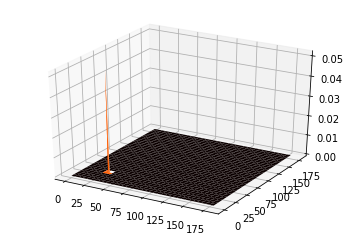

In [303]:
# Scale from all degrees of azimuth and elevation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
X = incident_thetas
Y = incident_phis
X, Y = np.meshgrid(X, Y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, DoA_spectrum, rstride = 5, cstride = 5, cmap = 'hot')


fig.savefig('full_scale.png')
plt.show()

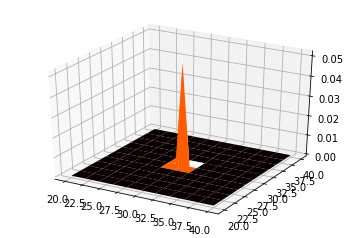

In [304]:
# Scale from ten degrees on both side of DoA

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
X = incident_thetas[(DoA[0]-10):(DoA[0]+11)]
Y = incident_phis[(DoA[1]-10):(DoA[1]+11)]
Z = DoA_spectrum[(DoA[0]-10):(DoA[0]+11), (DoA[1]-10):(DoA[1]+11)]
X, Y = np.meshgrid(X, Y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, Z, rstride = 2, cstride = 2, cmap = 'hot')

fig.savefig('ten_degree_scale.png')
plt.show()

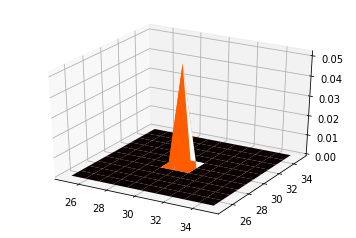

In [305]:
# Scale from 3 degrees on both sides of DoA

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plt.axes(projection='3d')
X = incident_thetas[(DoA[0]-5):(DoA[0]+6)]
Y = incident_phis[(DoA[1]-5):(DoA[1]+6)]
Z = DoA_spectrum[(DoA[0]-5):(DoA[0]+6), (DoA[1]-5):(DoA[1]+6)]
X, Y = np.meshgrid(X, Y)  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'hot')

fig.savefig('five_degree_scale.png')
plt.show()

# Ways to Optimize/Going Further

### For DoA Optimization:
#### Change the number of samples, N, used in 'training' the algorithm. More samples = more accuracy, but it also takes more computational time. 
### Going Further:
#### In real time, start N at low number, then increase by a set amount each time. Continue increasing N until DoA converges to a certain value with a maximum amount of variance.